In [35]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

# Silence pipeline init logs unless overridden upstream
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_DataPipeline as mndws_dp
WildfireDataset = mndws_dp.WildfireDataset
WildfirePaths = mndws_dp.WildfirePaths
CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

if torch.cuda.is_available():
    device = torch.device("cuda")
    # Enable cuDNN autotuner only when CUDA is active
    try:
        torch.backends.cudnn.benchmark = True
    except Exception:
        pass
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

use_cuda = device.type == "cuda"
use_mps = device.type == "mps"
print("Device:", device)

Device: mps


In [45]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles and loaders ---
try:
    mndws_dp
except NameError:
    import os
    os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
    import mNDWS_DataPipeline as mndws_dp
    WildfireDataset = mndws_dp.WildfireDataset
    WildfirePaths = mndws_dp.WildfirePaths
    CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
    CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = list(mndws_dp.USE_CHANNELS)  # adjust here if you want fewer features
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Reusing NPZ tiles from pipeline at: /Users/queclay/wildfire_npz_tiles_mndws_v1
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware, change number of epochs here
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)

# change number of epochs here
EPOCHS_LR = 50
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 21 pos_weight = 35.07989501953125


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.3446 | VAL AP 0.0377 | VAL F1* 0.0733 | thr≈0.525


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.3031 | VAL AP 0.0482 | VAL F1* 0.0918 | thr≈0.577


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2546 | VAL AP 0.0625 | VAL F1* 0.1142 | thr≈0.618


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2679 | VAL AP 0.0752 | VAL F1* 0.1351 | thr≈0.647


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.2465 | VAL AP 0.0822 | VAL F1* 0.1478 | thr≈0.656


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1892 | VAL AP 0.0906 | VAL F1* 0.1619 | thr≈0.664


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.2036 | VAL AP 0.0987 | VAL F1* 0.1778 | thr≈0.675


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.2043 | VAL AP 0.1055 | VAL F1* 0.1906 | thr≈0.691


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1810 | VAL AP 0.1168 | VAL F1* 0.2086 | thr≈0.695


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.1697 | VAL AP 0.1250 | VAL F1* 0.2227 | thr≈0.701


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.1531 | VAL AP 0.1304 | VAL F1* 0.2340 | thr≈0.700


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1037 | VAL AP 0.1426 | VAL F1* 0.2518 | thr≈0.706


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.1633 | VAL AP 0.1543 | VAL F1* 0.2669 | thr≈0.712


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1447 | VAL AP 0.1649 | VAL F1* 0.2806 | thr≈0.717


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.1127 | VAL AP 0.1744 | VAL F1* 0.2934 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.1360 | VAL AP 0.1730 | VAL F1* 0.2979 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.1368 | VAL AP 0.1791 | VAL F1* 0.3043 | thr≈0.729


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.1231 | VAL AP 0.1928 | VAL F1* 0.3193 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.1338 | VAL AP 0.1997 | VAL F1* 0.3287 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.1115 | VAL AP 0.2057 | VAL F1* 0.3384 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0972 | VAL AP 0.2124 | VAL F1* 0.3470 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.1051 | VAL AP 0.2160 | VAL F1* 0.3519 | thr≈0.736


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.1205 | VAL AP 0.2166 | VAL F1* 0.3544 | thr≈0.735


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0662 | VAL AP 0.2257 | VAL F1* 0.3685 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 1.0730 | VAL AP 0.2318 | VAL F1* 0.3735 | thr≈0.731


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 1.0284 | VAL AP 0.2338 | VAL F1* 0.3777 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.0462 | VAL AP 0.2398 | VAL F1* 0.3866 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0178 | VAL AP 0.2418 | VAL F1* 0.3911 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 1.0419 | VAL AP 0.2408 | VAL F1* 0.3894 | thr≈0.733


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 1.0379 | VAL AP 0.2423 | VAL F1* 0.3923 | thr≈0.731


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 1.0453 | VAL AP 0.2459 | VAL F1* 0.3982 | thr≈0.739


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 1.0170 | VAL AP 0.2481 | VAL F1* 0.4011 | thr≈0.750


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 1.0567 | VAL AP 0.2510 | VAL F1* 0.4077 | thr≈0.762


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 1.0756 | VAL AP 0.2490 | VAL F1* 0.4065 | thr≈0.759


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 1.0500 | VAL AP 0.2491 | VAL F1* 0.4116 | thr≈0.765


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 1.0281 | VAL AP 0.2488 | VAL F1* 0.4102 | thr≈0.760


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 1.0471 | VAL AP 0.2489 | VAL F1* 0.4110 | thr≈0.774


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 1.0308 | VAL AP 0.2482 | VAL F1* 0.4120 | thr≈0.775


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 1.0082 | VAL AP 0.2475 | VAL F1* 0.4106 | thr≈0.781


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 1.0554 | VAL AP 0.2459 | VAL F1* 0.4090 | thr≈0.790


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 1.0281 | VAL AP 0.2476 | VAL F1* 0.4140 | thr≈0.787


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 1.0177 | VAL AP 0.2499 | VAL F1* 0.4166 | thr≈0.798


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 1.0221 | VAL AP 0.2513 | VAL F1* 0.4211 | thr≈0.794


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 1.0225 | VAL AP 0.2525 | VAL F1* 0.4223 | thr≈0.797


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 1.0165 | VAL AP 0.2525 | VAL F1* 0.4233 | thr≈0.801


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 0.9852 | VAL AP 0.2508 | VAL F1* 0.4231 | thr≈0.789


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 1.0066 | VAL AP 0.2522 | VAL F1* 0.4257 | thr≈0.767


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9952 | VAL AP 0.2522 | VAL F1* 0.4269 | thr≈0.776


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9952 | VAL AP 0.2522 | VAL F1* 0.4273 | thr≈0.778


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 1.0465 | VAL AP 0.2527 | VAL F1* 0.4283 | thr≈0.785


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.785 | AP=0.2339 | P=0.380 R=0.450 F1=0.412


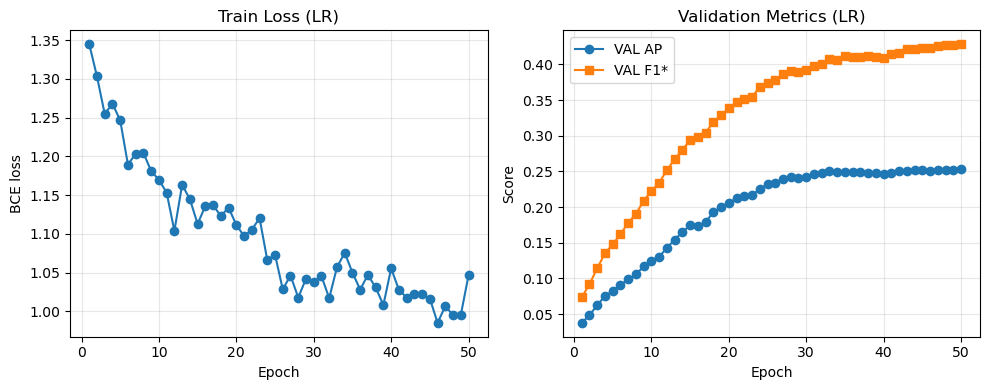

In [ ]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt

def train_lr_epoch():
    lr_model.train()
    losses = []
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

best_val_ap_lr = -1.0
best_state = None
train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []

for e in range(EPOCHS_LR):
    tr_loss = train_lr_epoch()
    ap, f1, thr = eval_lr(val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap_lr:
        best_val_ap_lr = ap
        best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

# Restore best model and recompute best threshold on VAL
if best_state is not None:
    lr_model.load_state_dict(best_state)

_, _, best_thr_val = eval_lr(val_loader)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

epochs = np.arange(1, len(train_loss_hist) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(epochs, train_loss_hist, marker="o")
axes[0].set_title("Train Loss (LR)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE loss")
axes[0].grid(True, alpha=0.3)
axes[1].plot(epochs, val_ap_hist, marker="o", label="VAL AP")
axes[1].plot(epochs, val_f1_hist, marker="s", label="VAL F1*")
axes[1].set_title("Validation Metrics (LR)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()


[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.4234
  gust_med         +0.4001
  erc              +0.2877
  wind_75          -0.2837
  pdsi             -0.2356
  temp             +0.2194
  barrier          -0.1925
  bi               +0.1795
  water            -0.1016
  fuel2            +0.0896
  slope            +0.0865
  rh               -0.0843
  ... (+9 more)
[LR] Bias: -0.5998


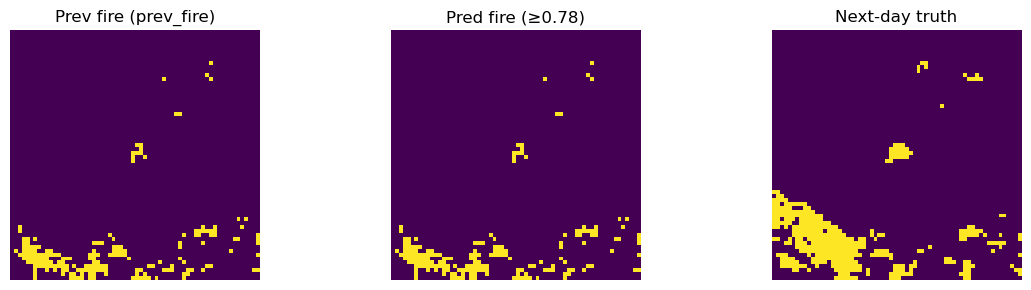

In [57]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout(); plt.show()

# Example
show_one_lr(test_ds, i=0)

In [58]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

# Choose a writable artifacts directory (override with $ARTIFACTS_DIR if desired)
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)

artifact = {
    "state_dict": lr_model.state_dict(),
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),         # preserve input order
    "mean": meanC.cpu(),                         # channel-aware stats
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
}

out_path = os.path.join(ART_DIR, "pixel_logreg.pt")
torch.save(artifact, out_path)
print(f"Saved model → {out_path}")

Saved model → /Users/queclay/wildfire_artifacts/lr/pixel_logreg.pt


In [59]:
test_ap_lr, test_f1_lr

(0.23389522699467966, 0.4119846603255972)

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2527 F1*=0.4283 thr≈0.785
VAL @thr: {'tp': 16736, 'fp': 24104, 'tn': 1167391, 'fn': 20569, 'precision': 0.4097943192947087, 'recall': 0.448626189518711, 'f1': 0.42833194203168456}
TEST @thr: {'tp': 17463, 'fp': 28482, 'tn': 1161488, 'fn': 21367, 'precision': 0.3800848841004723, 'recall': 0.44972959052267586, 'f1': 0.4119846603255972}
VAL @thr: {'tp': 16736, 'fp': 24104, 'tn': 1167391, 'fn': 20569, 'precision': 0.4097943192947087, 'recall': 0.448626189518711, 'f1': 0.42833194203168456}
TEST @thr: {'tp': 17463, 'fp': 28482, 'tn': 1161488, 'fn': 21367, 'precision': 0.3800848841004723, 'recall': 0.44972959052267586, 'f1': 0.4119846603255972}


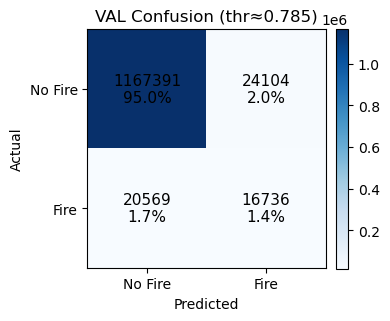

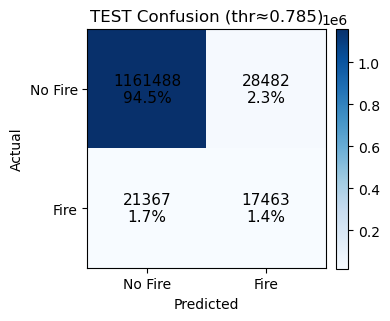

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))

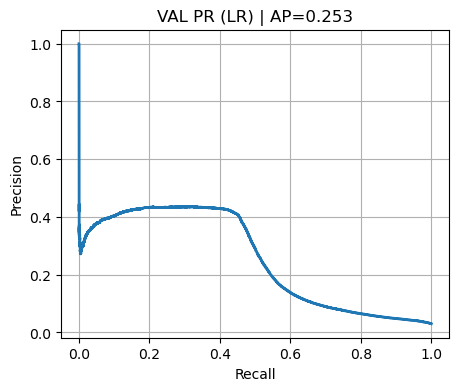

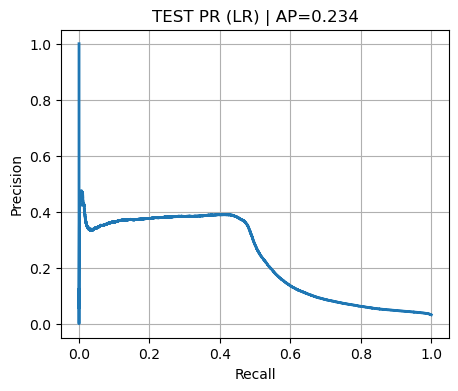

In [61]:
import matplotlib.pyplot as plt
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True); plt.show()

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [62]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  chili             AP=0.032  F1*=0.063
  pr                AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
